In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import requests
import pandas as pd
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm

# IMPORT DATA
## 1. 바이러스 확진자 수 데이터
### (1) 데이터 가져오기
> - 감염현황 데이터 수집
> - 2020년 2월 17일 ~ 2020년 9월 1일

In [2]:
# api private key
key = ''

In [3]:
# 데이터 가져오기
def get_data(key, data_name, numrows, startdate, enddate):
    
    url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/' + data_name + '?serviceKey=' + key
    header_params = {'pageNo': '1', 'numOfRows': str(numrows), 'startCreateDt': str(startdate), 'endCreateDt': str(enddate)}
    response = requests.get(url, params=header_params)
    
    if (response.status_code == 200) & (('<resultCode>99' in response.text) != True):
        return BeautifulSoup(response.content, 'xml')
    else:
        return print("Error code:", response.status_code)

In [4]:
startdate = 20200217
enddate = 20200901

nm = ['getCovid19InfStateJson'] #감염현황
nm_data = ['state']

col1 = ['seq','stateDt','decideCnt','clearCnt','examCnt','deathCnt','careCnt','resutlNegCnt','accExamCnt','accExamCompCnt','accDefRate','createDt','updateDt']
        # seq, 기준일, 확진자 수, 격리해제 수, 검사진행 수, 사망자 수, 치료중 환자 수, 결과 음성 수, 누적 검사 수, 누적 검사 완료 수, 누적 확진률, 등록일시분초, 수정일시분초
col = [col1]

for i in range(len(nm)):
    
    exec('{} = pd.DataFrame()'.format(nm_data[i]))
    df = get_data(key, nm[i], 1000, startdate, enddate)

    for j in col[i]:
        
        data = df.find_all(j)
        data = [x.text for x in data]
        data = pd.Series(data).to_frame()
        exec('{}["{}"] = data[0]'.format(nm_data[i], j))

    print(nm[i], '-->', nm_data[i])

getCovid19InfStateJson --> state


----
### (2) 데이터 확인
> - 'stateDt'(기준일) 데이터의 unique값 수와 count수가 다른 것을 확인 ==> 기준일이 중복인 것들이 있음
> - 기준일 중복 데이터 정제를 위해 기준일의 'createDt'(등록일시분초)가 최신인 것만 남김

In [5]:
# 데이터 확인
state.describe()

,seq,stateDt,decideCnt,clearCnt,examCnt,deathCnt,careCnt,resutlNegCnt,accExamCnt,accExamCompCnt,accDefRate,createDt,updateDt
count,213,213,213,213,213,213,183,183,183,183,213,213,213
unique,213,193,206,191,207,124,171,179,180,180,181,213,18
top,82,20200218,31,16,9259,305,1008,575184,348582,413858,,2020-04-12 10:20:49.49,null
freq,1,3,3,4,3,9,3,3,2,2,30,1,119


In [6]:
# 날짜 중복인 데이터들이 존재
state['stateDt'].value_counts()

20200218    3
20200425    3
20200221    3
20200223    2
20200229    2
           ..
20200502    1
20200724    1
20200711    1
20200619    1
20200527    1
Name: stateDt, Length: 193, dtype: int64

In [7]:
# createDt가 과거인 것은 제거
state['createDt'] = pd.to_datetime(state['createDt'], format='%Y-%m-%d %H:%M:%S')
state = state.sort_values(['stateDt', 'createDt']).reset_index(drop=True)
state = state.loc[state.groupby('stateDt')['createDt'].idxmax()]

# 데이터 확인
state.describe()

,seq,stateDt,decideCnt,clearCnt,examCnt,deathCnt,careCnt,resutlNegCnt,accExamCnt,accExamCompCnt,accDefRate,createDt,updateDt
count,193,193,193,193,193,193,179,179,179,179,193,193,193
unique,193,193,193,190,193,120,171,179,179,179,180,193,17
top,82,20200405,14150,16,8429,282,1008,1435120,196618,1470320,,2020-03-09 10:47:15.150000,null
freq,1,1,1,2,1,9,3,1,1,1,14,1,119
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-17 16:50:47.470000,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-27 10:15:47.305000,NaN


----
### (3) 확진자/사망자 일별 수 계산
> - 확진자/사망자 수: 누적 수
> - 검사진행 수: 일별수


In [8]:
# 확진자/사망자 수 일간 증감 수
def difference(dataset, interval=1):
	diff = [dataset[0]]
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

virus_state = state[['stateDt','decideCnt','examCnt','deathCnt']].reset_index(drop=True) # 기준일, 확진자 수, 검사진행 수, 사망자 수
virus_state[['decideCnt', 'examCnt', 'deathCnt']] = virus_state[['decideCnt', 'examCnt', 'deathCnt']].apply(pd.to_numeric)
virus_state['stateDt'] = pd.to_datetime(virus_state['stateDt'], format='%Y%m%d')
virus_state = virus_state.sort_values(['stateDt']).reset_index(drop=True)

virus_state['decide'] = pd.DataFrame(difference(virus_state['decideCnt'])) # 확진자 수
virus_state['death'] =  pd.DataFrame(difference(virus_state['deathCnt'])) # 사망자 수

virus_state.head()

,stateDt,decideCnt,examCnt,deathCnt,decide,death
0,2020-02-17,30,708,0,30,0
1,2020-02-18,31,818,0,1,0
2,2020-02-19,51,1149,0,20,0
3,2020-02-20,104,1860,1,53,1
4,2020-02-21,204,3180,1,100,0


In [9]:
virus_state[['decide','death','examCnt']].describe()

,decide,death,examCnt
count,193.000000,193.000000,193.000000
mean,96.922280,1.621762,19468.093264
std,135.164287,2.070865,8309.184746
min,1.000000,0.000000,708.000000
25%,27.000000,0.000000,15298.000000
50%,46.000000,1.000000,19089.000000
75%,93.000000,2.000000,22278.000000
max,813.000000,9.000000,52795.000000


-----
### (4) 데이터 시각화
> - 2020년 2월말 신천지로 인해 검사진행 수가 급증하였으며, 일별 확진자 수 800명 초과함. 이후 3월 초에 검사진행 수가 떨어지며 일별 확진자 수도 감소함.
> - 5월 중순 이태원으로 인해 검사진행 수가 2만건 가까이 급증하였지만, 검사진행 대비 확진자 수(확진률)은 신천지에 비해 낮음. 이러한 추이는 8월 초까지 나타남.
> - 8월15일 광화문 집회 이후 일별 검사진행 수가 처음으로 4만건을 초과하였으며, 확진자 수도 급증하는 추이를 보임.
> - 이러한 추이를 보이는 원인은 여름 휴가철이라는 점, 깜깜이 확진자가 존재할 수 있다는 점 그리고 8.15광화문집회 때문이라고 추정.

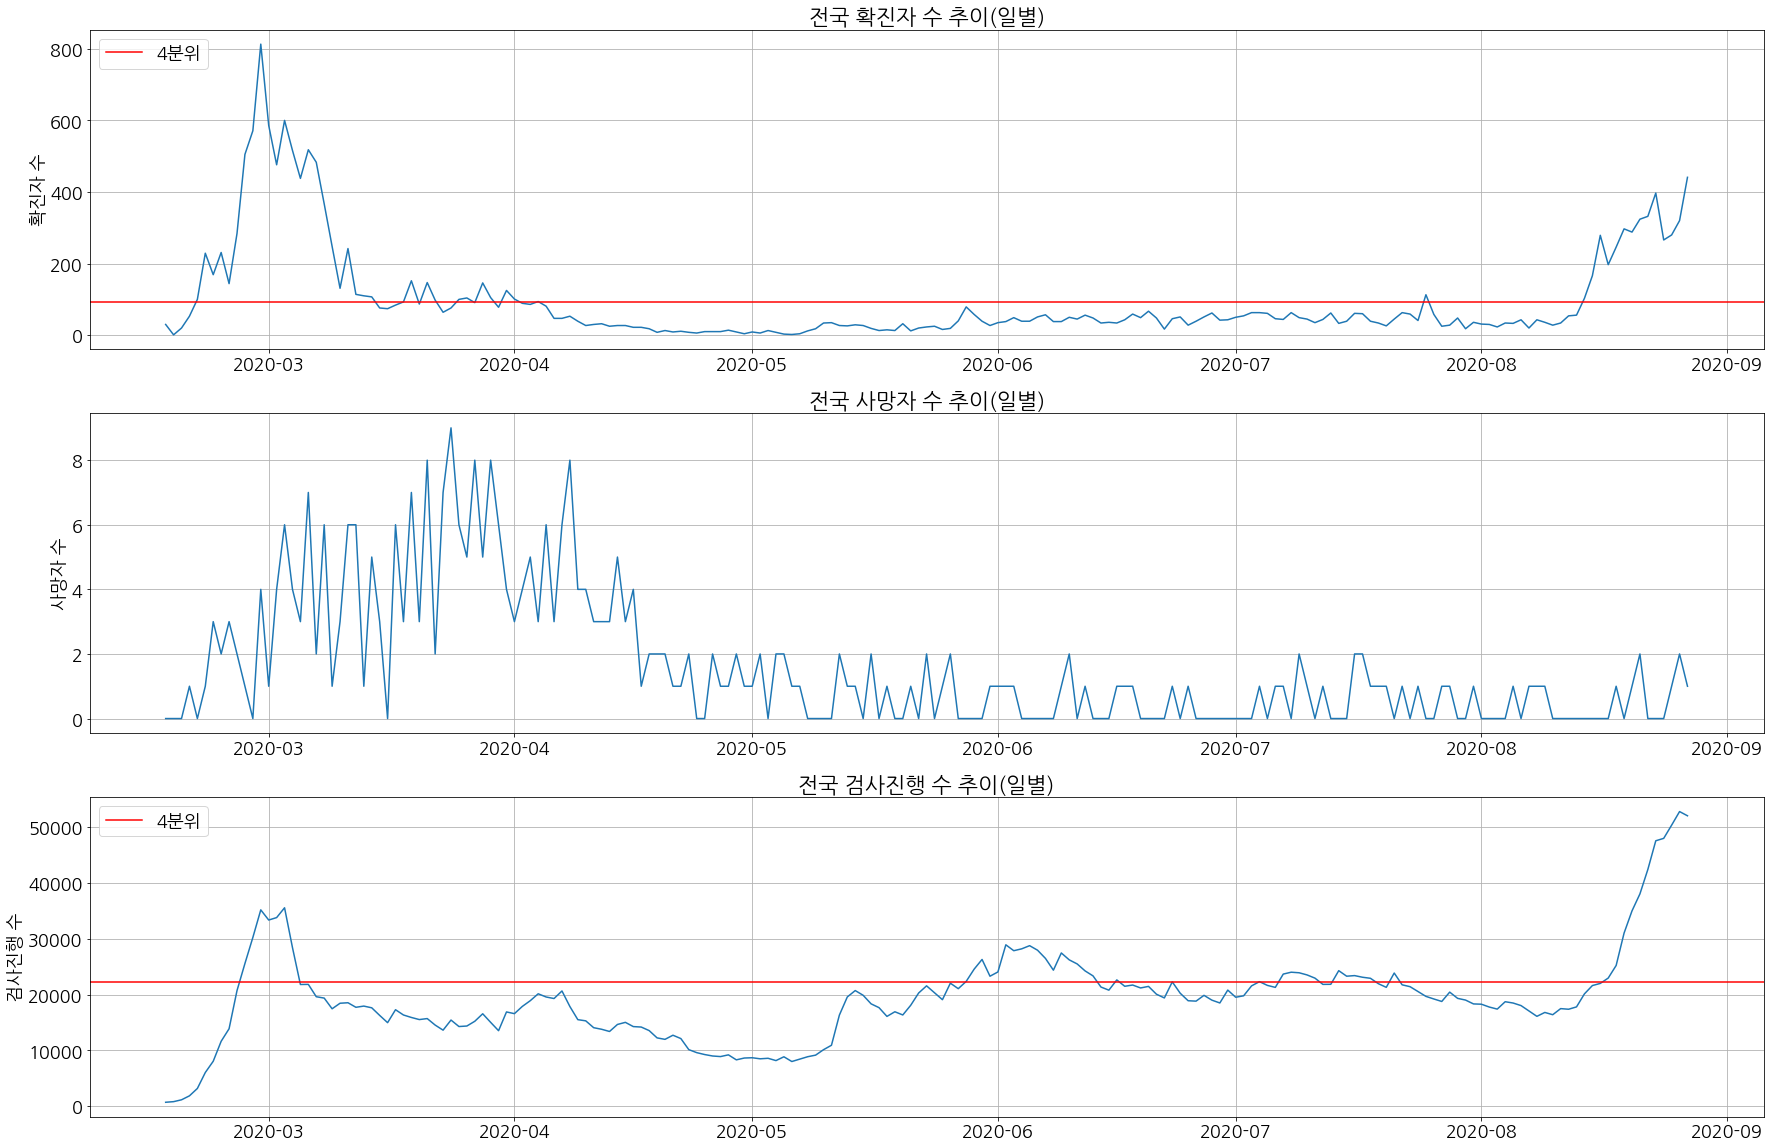

In [10]:
# 추이

rc('font', family='NanumGothic', size=18)
mpl.rcParams['axes.unicode_minus'] = False

index = list(virus_state[virus_state.groupby(virus_state['stateDt'].map(lambda x:x.month))['stateDt'].transform('min') == virus_state['stateDt']].index)
label = list(virus_state[virus_state.groupby(virus_state['stateDt'].map(lambda x:x.month))['stateDt'].transform('min') == virus_state['stateDt']]['stateDt'].astype(str))

fig, ax = plt.subplots(3, 1, figsize=(30, 20))

ax[0].plot(virus_state['stateDt'], virus_state['decide'])
ax[0].set_title('전국 확진자 수 추이(일별)')
ax[0].set_ylabel('확진자 수')
ax[0].axhline(virus_state['decide'].quantile(q=0.75, interpolation='nearest'), color='r', label='4분위') # 4분위
ax[0].legend(loc='upper left')
ax[0].grid()

ax[1].plot(virus_state['stateDt'], virus_state['death'])
ax[1].set_title('전국 사망자 수 추이(일별)')
ax[1].set_ylabel('사망자 수')
ax[1].grid()

ax[2].plot(virus_state['stateDt'], virus_state['examCnt'])
ax[2].set_title('전국 검사진행 수 추이(일별)')
ax[2].set_ylabel('검사진행 수')
ax[2].axhline(virus_state['examCnt'].quantile(q=0.75, interpolation='nearest'), color='r', label='4분위') # 4분위
ax[2].legend(loc='upper left')
ax[2].grid()


plt.show()

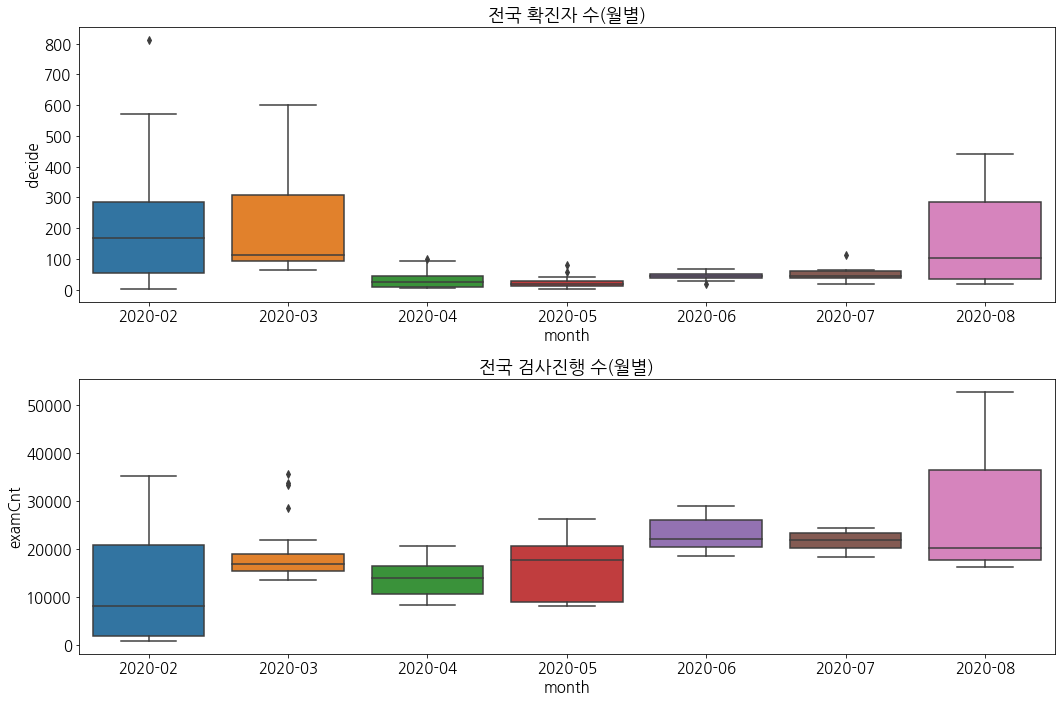

In [11]:
# boxplot
plt.rc('font', size=15)
virus_state['month'] = virus_state['stateDt'].apply(lambda x:x.strftime('%Y-%m'))

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.boxplot(x='month', y='decide', data=virus_state, ax=ax[0])
ax[0].set_title('전국 확진자 수(월별)')
sns.boxplot(x='month', y='examCnt', data=virus_state, ax=ax[1])
ax[1].set_title('전국 검사진행 수(월별)')

plt.tight_layout()
plt.show()

-----
-----
## 2. KOSPI index 데이터  
- 참고: pykrx [https://github.com/sharebook-kr/pykrx.git]
### (1) 데이터 가져오기
> - KOSPI index 중 코스피, 코스피 200 종목별 지수만 가져오기
> - ~~전일 대비 등락률 = (당일 종가 - 전일 종가) / 전일 종가 * 100~~

In [12]:
#!pip install pykrx
from pykrx import stock

In [13]:
print(stock.get_index_ticker_list())
stock_list = ['코스피', '코스피 200', '코스피 200 커뮤니케이션서비스', '코스피 200 건설', '코스피 200 중공업', '코스피 200 철강/소재', 
              '코스피 200 에너지/화학', '코스피 200 정보기술', '코스피 200 금융', '코스피 200 생활소비재', '코스피 200 경기소비재', 
              '코스피 200 산업재', '코스피 200 헬스케어']

['코스피', '코스피 200', '코스피 100', '코스피 50', '코스피 200 중소형주', '코스피 200 초대형제외 지수', '코스피200제외 코스피지수', '코스피 200 커뮤니케이션서비스', '코스피 200 건설', '코스피 200 중공업', '코스피 200 철강/소재', '코스피 200 에너지/화학', '코스피 200 정보기술', '코스피 200 금융', '코스피 200 생활소비재', '코스피 200 경기소비재', '코스피 200 산업재', '코스피 200 헬스케어', '음식료품', '섬유의복', '종이목재', '화학', '의약품', '비금속광물', '철강금속', '기계', '전기전자', '의료정밀', '운수장비', '유통업', '전기가스업', '건설업', '운수창고업', '통신업', '금융업', '은행', '증권', '보험', '서비스업', '제조업', '코스피 대형주', '코스피 중형주', '코스피 소형주', '코스피 200 비중상한 30%', '코스피 200 비중상한 25%', '코스피 200 비중상한 20%']


In [14]:
# 종가 데이터

def ratio(fin, interval=1):
	diff = [np.nan]
	for i in range(interval, len(fin)):
		value = fin[i]
        #value = ( fin[i] - fin[i - interval] ) / fin[i - interval] * 100
		diff.append(value)
	return pd.Series(diff)

In [15]:
data = virus_state[['stateDt','month','decide','examCnt','death']].reset_index(drop=True)

for i in tqdm(range(len(stock_list))):
    
    stock1 = stock.get_index_ohlcv_by_date(str(startdate), str(enddate), stock_list[i]).reset_index()
    stock1['price'] = ratio(stock1['종가'])
    stock1 = stock1[['날짜','price','거래량']]
    stock1.rename(columns = {'날짜': 'stateDt', 
                             'price': 'price_'+stock_list[i], 
                             '거래량': 'vol_'+stock_list[i]}, inplace=True)

#    stock1['ratio'] = ratio(stock1['종가'])
#    stock1 = stock1[['날짜','ratio','거래량']]
#    stock1.rename(columns = {'날짜': 'stateDt', 
#                             'ratio': 'ratio_'+stock_list[i], 
#                             '거래량': 'vol_'+stock_list[i]}, inplace=True)
    
    data = pd.merge(data, stock1, on=['stateDt'], how='left')
data.head()

100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


,stateDt,month,decide,examCnt,death,price_코스피,vol_코스피,price_코스피 200,vol_코스피 200,price_코스피 200 커뮤니케이션서비스,...,price_코스피 200 금융,vol_코스피 200 금융,price_코스피 200 생활소비재,vol_코스피 200 생활소비재,price_코스피 200 경기소비재,vol_코스피 200 경기소비재,price_코스피 200 산업재,vol_코스피 200 산업재,price_코스피 200 헬스케어,vol_코스피 200 헬스케어
0,2020-02-17,2020-02,30,708,0,NaN,458248000.0,NaN,84276000.0,NaN,...,NaN,12534000.0,NaN,4317000.0,NaN,8931000.0,NaN,4241000.0,NaN,16402000.0
1,2020-02-18,2020-02,1,818,0,2208.88,470425000.0,297.74,84753000.0,1837.84,...,595.79,13256000.0,1081.82,4120000.0,1358.90,9182000.0,446.07,4061000.0,1883.71,4864000.0
2,2020-02-19,2020-02,20,1149,0,2210.34,591155000.0,298.33,84259000.0,1870.50,...,593.28,17022000.0,1080.33,4918000.0,1352.27,8921000.0,444.24,3650000.0,1874.09,4066000.0
3,2020-02-20,2020-02,53,1860,1,2195.50,709564000.0,296.65,90010000.0,1859.23,...,591.81,15670000.0,1060.69,6503000.0,1331.15,10185000.0,437.02,3576000.0,1850.19,3634000.0
4,2020-02-21,2020-02,100,3180,0,2162.84,635474000.0,292.42,100708000.0,1843.78,...,583.94,19594000.0,1051.82,5526000.0,1310.42,15340000.0,430.74,4023000.0,1809.84,3808000.0


----
### (2) 데이터 확인하기
> - 공휴일 가격은 이전날 종가를 이용

In [16]:
data.iloc[:, 5:].describe()

,price_코스피,vol_코스피,price_코스피 200,vol_코스피 200,price_코스피 200 커뮤니케이션서비스,vol_코스피 200 커뮤니케이션서비스,price_코스피 200 건설,vol_코스피 200 건설,price_코스피 200 중공업,vol_코스피 200 중공업,...,price_코스피 200 금융,vol_코스피 200 금융,price_코스피 200 생활소비재,vol_코스피 200 생활소비재,price_코스피 200 경기소비재,vol_코스피 200 경기소비재,price_코스피 200 산업재,vol_코스피 200 산업재,price_코스피 200 헬스케어,vol_코스피 200 헬스케어
count,132.000000,1.330000e+02,132.00000,1.330000e+02,132.000000,1.330000e+02,132.000000,1.330000e+02,132.000000,1.330000e+02,...,132.000000,1.330000e+02,132.000000,1.330000e+02,132.000000,1.330000e+02,132.000000,1.330000e+02,132.000000,1.330000e+02
mean,2046.671061,8.592598e+08,272.64697,1.998357e+08,2049.323030,7.891850e+06,186.115833,1.483041e+07,204.122879,3.042267e+07,...,497.140152,3.349623e+07,1003.715606,9.475895e+06,1142.798030,1.867272e+07,385.171667,1.218686e+07,2296.324167,1.864035e+07
std,209.959134,2.221005e+08,26.83166,6.704942e+07,341.911049,2.265283e+06,19.902072,1.239880e+07,26.536733,3.033288e+07,...,44.418597,1.815541e+07,67.488277,4.003045e+06,133.856488,7.419897e+06,32.269641,1.120230e+07,446.050728,1.340559e+07
min,1457.640000,4.582480e+08,199.28000,8.425900e+07,1411.940000,3.411000e+06,115.750000,4.441000e+06,129.370000,5.789000e+06,...,355.350000,1.224300e+07,790.910000,4.120000e+06,791.250000,8.736000e+06,275.480000,3.576000e+06,1427.960000,3.030000e+06
25%,1920.310000,6.994470e+08,253.77750,1.513580e+08,1750.282500,6.467000e+06,179.787500,8.336000e+06,183.405000,1.415400e+07,...,474.675000,2.239300e+07,972.625000,6.891000e+06,1053.297500,1.354200e+07,371.527500,6.050000e+06,1914.677500,9.000000e+06
50%,2082.150000,8.302660e+08,278.93000,1.891290e+08,2067.240000,7.595000e+06,191.560000,1.178400e+07,215.135000,2.155000e+07,...,499.505000,2.882400e+07,1019.775000,8.678000e+06,1134.205000,1.666700e+07,390.930000,8.658000e+06,2159.595000,1.606200e+07
75%,2190.565000,9.681250e+08,290.93750,2.489300e+08,2348.730000,8.859000e+06,198.070000,1.737800e+07,223.525000,3.373600e+07,...,519.572500,3.806000e+07,1043.142500,1.061000e+07,1226.070000,2.084800e+07,403.795000,1.341600e+07,2690.580000,2.332900e+07
max,2437.530000,1.984182e+09,323.33000,4.765040e+08,2671.680000,1.672200e+07,213.930000,1.021990e+08,244.050000,1.790080e+08,...,595.790000,1.310610e+08,1139.460000,2.827600e+07,1440.410000,5.251700e+07,446.070000,8.841700e+07,3112.390000,7.487000e+07


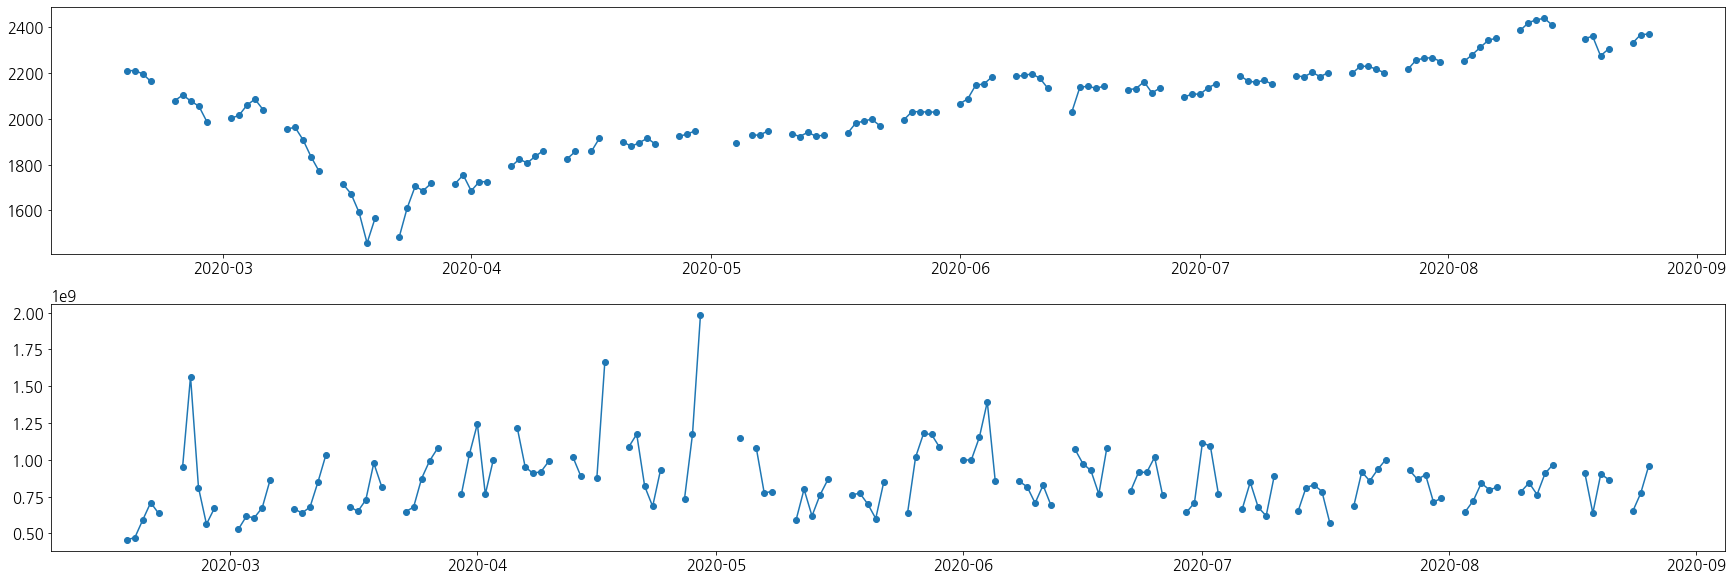

In [17]:
# 데이터 확인 위해 코스피 지수 plot
fig, ax = plt.subplots(2, 1, figsize=(30, 10))

ax[0].plot(data['stateDt'], data['price_코스피'], 'o-')
ax[1].plot(data['stateDt'], data['vol_코스피'], 'o-')
plt.show()

In [18]:
# 공휴일의 경우 null값 ==> 이전 등락률로 채워주기
data.fillna(method='ffill', inplace=True)

-----
### (3) 데이터 시각화
> **1) KOSPI Index**
> - range_date; 코로나 검사진행 수가 급증했던 신천지, 이태원, 8.15이후

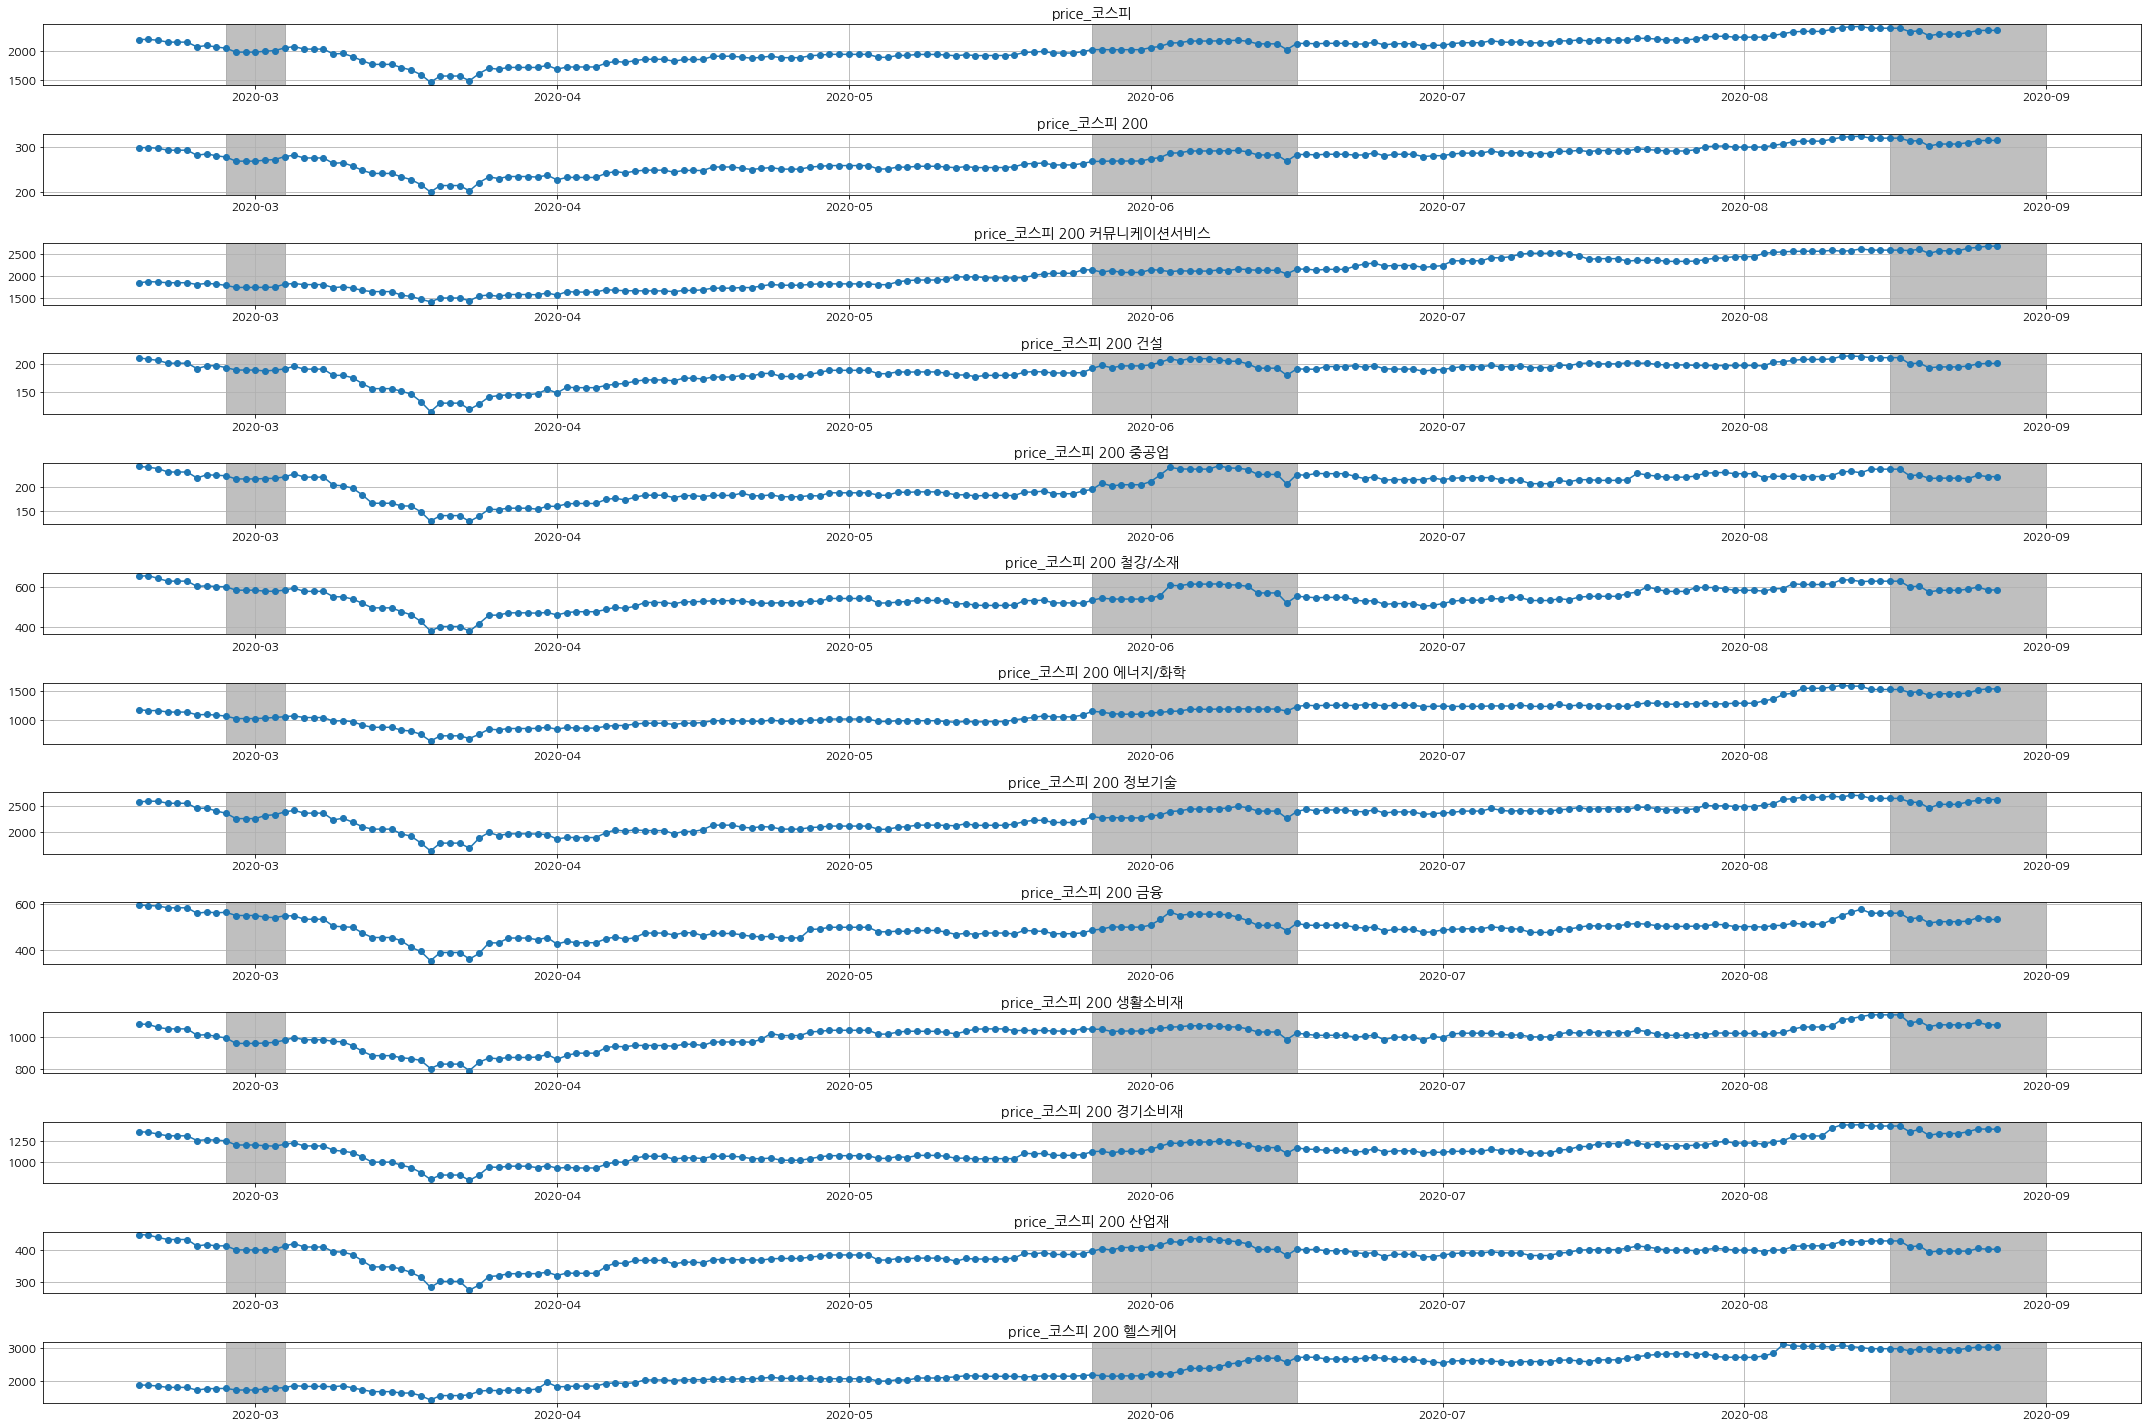

In [19]:
# index별 등락률 (검사진행 수 4분위 수 이상인 구간은 회색배경)
from datetime import datetime
range_date = [(datetime(2020,2,27), datetime(2020,3,4)),
              (datetime(2020,5,26), datetime(2020,6,16)),
              (datetime(2020,8,16), datetime(2020,9,1))]


plt.rc('font', size=12) 
fig, ax = plt.subplots(len(data.columns[data.columns.str.contains('price')]), 1, figsize=(30, 20))

for i in range(len(data.columns[data.columns.str.contains('price')])):
    
    ax[i].plot(data['stateDt'], data[data.columns[data.columns.str.contains('price')][i]], 'o-')
    ax[i].set_title(data.columns[data.columns.str.contains('price')][i])
    ax[i].grid()
    for (start, end) in range_date:
        ax[i].axvspan(start, end, color='gray', alpha=0.5)
    
plt.tight_layout()
plt.show()

> **2) 상관관계**
> - 확진자 수와 지수등락률간 음의 상관관계가 가장 크게 나타남. 특히 코스피200 생활소비재, 경기소비재, 에너지/화학, 정보기술 지수


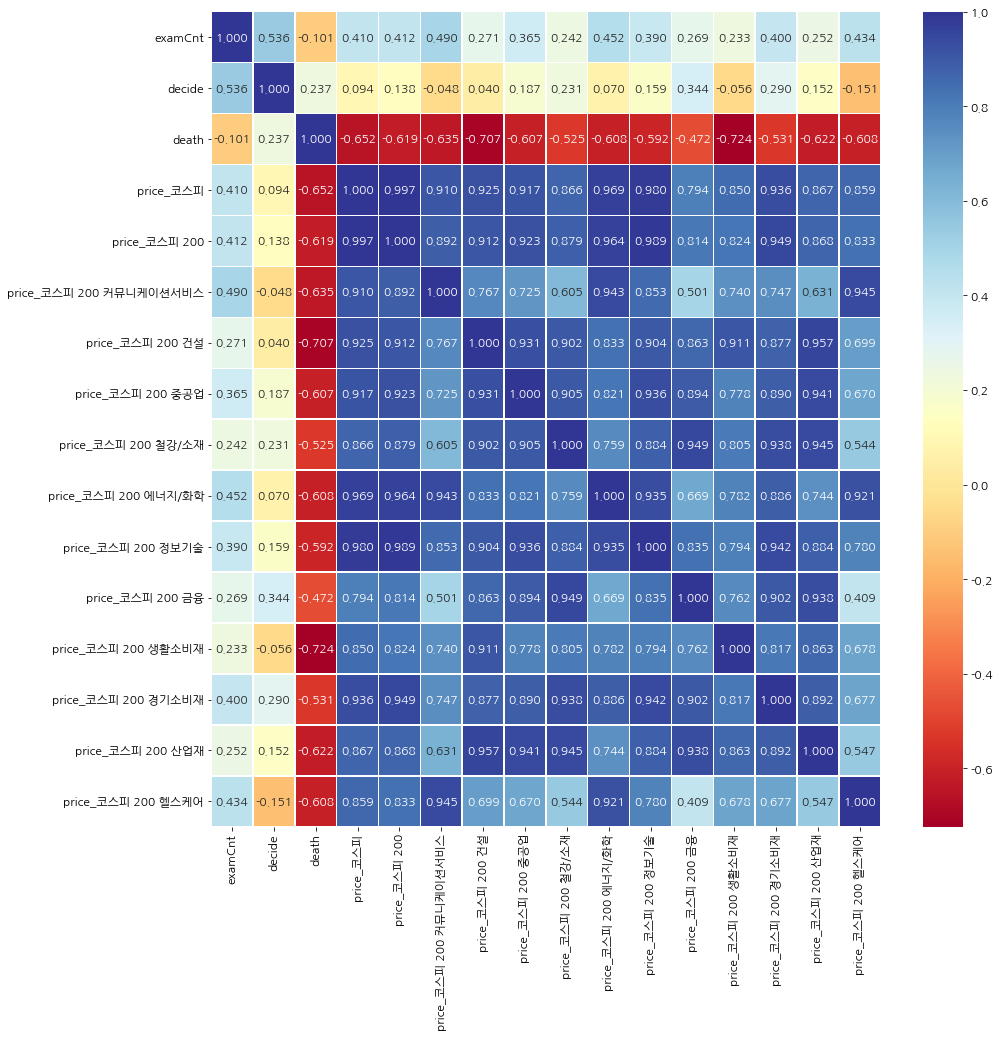

In [20]:
plt.rc('font', size=12) 
plt.figure(figsize=(15,15))
sns.heatmap(data=data[['examCnt','decide','death'] + list(data.columns[data.columns.str.contains('price')])].corr(), 
            annot=True, fmt='.3f', linewidths=.5, cmap='RdYlBu')
plt.show()

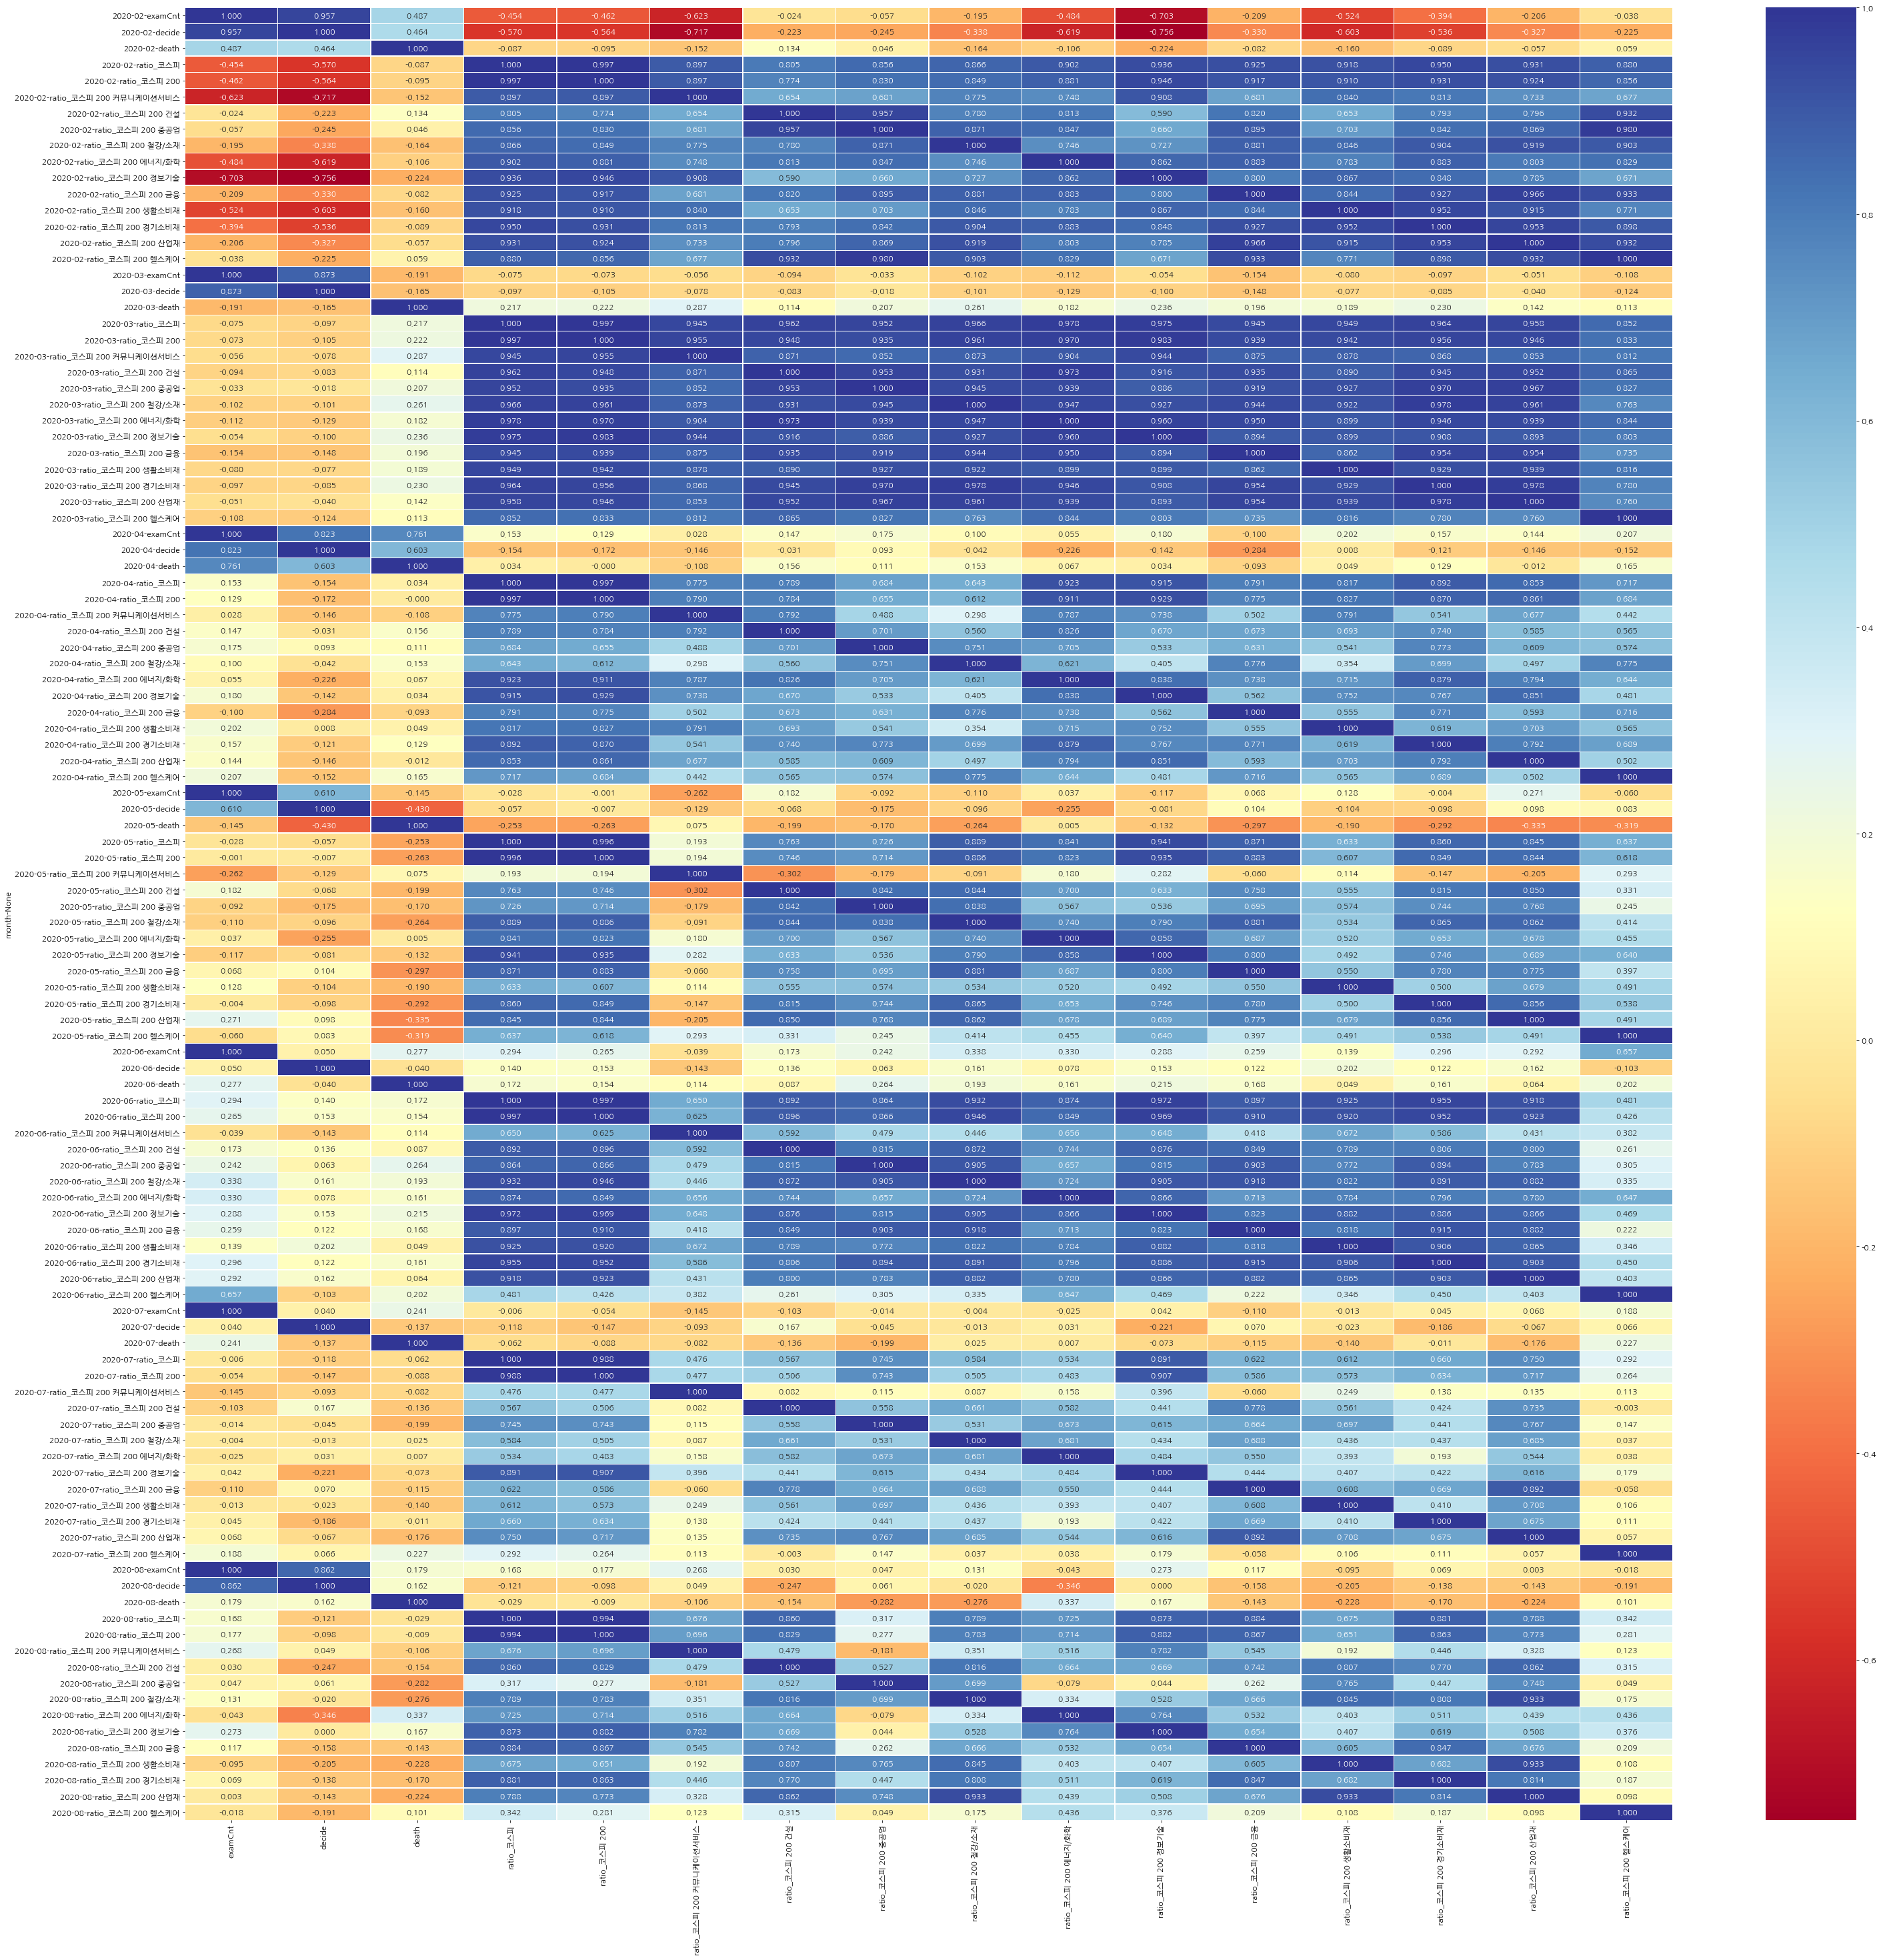

In [111]:

plt.rc('font', size=12) 
plt.figure(figsize=(50,50))
sns.heatmap(data=data.groupby('month')[['examCnt','decide','death'] + list(data.columns[data.columns.str.contains('ratio')])].corr(), annot=True, fmt='.3f', linewidths=.5, cmap='RdYlBu')
plt.show()